In [1]:
# Multi-Task Feature Learning using NumPy and SciPy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from custom_functions import processing
import pandas as pd 

In [2]:
# import data
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\data_v10.xlsx'
dataset = pd.read_excel(file_path)
dataset = dataset.drop(['Foldername'], axis=1)
dataset.head()

,Gender,VINCQ32DDN,VINICODEX003,FROPCOM0001,FROPCOM0005,FROPCOM0006_S1_,FROPCOM0006_S2_,FROPCOM0006_S3_,FROPCOM0006_S4_,FROPCOM0006_S5_,...,HADS_D_Score,grip,walk_time_4m,Item_1,Item_2,Item_3,Item_4,Item_5,Fried_Score,Fried_State
0,0,76.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,1.0,...,9,NaN,8.45,0.0,0,1.0,1.0,NaN,2,0
1,0,75.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,9,21.5,6.11,0.0,0,1.0,1.0,1.0,3,1
2,0,67.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,10,23.2,20.00,0.0,0,0.0,1.0,1.0,2,0
3,0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,15,17.7,4.87,0.0,1,0.0,0.0,1.0,2,0
4,1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,40.0,3.48,0.0,0,0.0,0.0,1.0,1,0


In [ ]:
data = pd

In [3]:
data_imputed, _ = processing(dataset, 5, [3,5,7,9,11], False)
data_imputed.shape

(97, 821)

In [4]:
data_imputed

array([[ 0.        , 76.        ,  0.        , ...,  0.72727273,
         2.        ,  0.        ],
       [ 0.        , 75.        ,  1.        , ...,  1.        ,
         3.        ,  1.        ],
       [ 0.        , 67.        ,  0.        , ...,  1.        ,
         2.        ,  0.        ],
       ...,
       [ 0.        , 72.        ,  0.        , ...,  0.72727273,
         0.        ,  0.        ],
       [ 1.        , 70.        ,  0.        , ...,  0.81818182,
         1.        ,  0.        ],
       [ 0.        , 67.        ,  1.        , ...,  0.81818182,
         2.        ,  0.        ]])

In [6]:
# feature names
feature_names = dataset.drop(['Fried_State','Fried_Score','Frailty_State','Frailty_Score', 
                              'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 
                              'Weight_Diff', 'HADS_D_Score', 'walk_time_4m', 'EXAMCLIN02', 'grip'], axis=1).columns.to_list()

# Features and Targets
X = dataset.drop(['Fried_State','Fried_Score','Frailty_State','Frailty_Score',
                  'Item_1','Item_2','Item_3','Item_4','Item_5',
                  'Weight_Diff', 'HADS_D_Score','walk_time_4m','EXAMCLIN02','grip'], axis=1).values

# The two tasks are Fried_State and Frailty_State
y = dataset[['Fried_State','Frailty_State']].values # The two tasks are 'Fried_State' and 'Frailty_State'


In [7]:
# Impute missing values 
X_imputed, _ = processing(X, n_splits=5, k_values=[1, 3, 5, 7, 9], verbose=False)

In [86]:
X_imputed.shape

(97, 807)

In [74]:
# Define the objective function with Focal Loss and a regularization term for feature sharing
def objective_function_focal(params, X, y, lambda_reg=0.1, alpha=0.25, gamma=2.0):
    num_features = X.shape[1]
    num_tasks = y.shape[1]
    
    # Reshape params into W (common feature matrix)
    W = params.reshape((num_features, num_tasks))
    
    # Compute the predictions (logits)
    logits = X.dot(W)

    # Clip logits for numerical stability       [TO DIG]
    #clipped_logits = np.clip(logits, -500, 500)
    
    # Compute probabilities using sigmoid function
    #probs = 1 / (1 + np.exp(-clipped_logits))
    probs = 1 / (1 + np.exp(-logits))

    # Clip probabilities for numerical stability    [TO DIG]
    probs = np.clip(probs, 1e-15, 1 - 1e-15)
    
    # Compute the Focal Loss for each task
    loss = -np.sum(alpha * ((1 - probs) ** gamma) * y * np.log(probs) + (1 - alpha) * (probs ** gamma) * (1 - y) * np.log(1 - probs))
    
    # Add regularization term (Frobenius norm)
    loss += lambda_reg * np.linalg.norm(W, 'fro')
    
    return loss
    

In [75]:
# Initial guess for the common feature matrix W
initial_guess = np.random.rand(X_imputed.shape[1] * y.shape[1])

# Run the optimization to minimize the objective function with Focal Loss
result_focal = minimize(fun=objective_function_focal, 
                        x0=initial_guess, 
                        args=(X_imputed, y, 0.1, 0.25, 2.0), 
                        method='L-BFGS-B')


C:\Users\matth\AppData\Local\Temp\ipykernel_13632\3644959029.py:17: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-logits))


In [76]:
# Extract the optimized W (common feature matrix) for Focal Loss
optimized_W_focal = result_focal.x.reshape((X_imputed.shape[1], y.shape[1]))
optimized_W_focal


array([[-0.004,  0.002],
       [-0.005, -0.006],
       [-0.002,  0.001],
       ...,
       [-0.003,  0.001],
       [ 0.005,  0.003],
       [-0.001, -0.005]])

In [25]:
# Define the objective function with Hinge Loss and a regularization term for feature sharing
def objective_function_hinge(params, X, y, lambda_reg=0.1):
    num_features = X.shape[1]
    num_tasks = y.shape[1]
    
    # Reshape params into W (common feature matrix)
    W = params.reshape((num_features, num_tasks))
    
    # Compute the predictions (logits)
    logits = X.dot(W)
    
    # Convert labels to +1 and -1 for hinge loss
    y_hinge = 2 * y - 1
    
    # Compute the Hinge Loss for each task
    loss = np.sum(np.maximum(0, 1 - y_hinge * logits))
    
    # Add regularization term (Frobenius norm)
    loss += lambda_reg * np.linalg.norm(W, 'fro')
    
    return loss


In [26]:
# intitial guess for the common feature matrix W
initial_guess2 = np.random.rand(X_imputed.shape[1] * y.shape[1])

# Run the optimization to minimize the objective function with Hinge Loss
result_hinge = minimize(
    fun=objective_function_hinge, 
    x0=initial_guess2, 
    args=(X_imputed, y, 0.1),  # lambda_reg set to 0.1
    method='L-BFGS-B'
)

In [27]:
# Extract the optimized W (common feature matrix) for Hinge Loss
optimized_W_hinge = result_hinge.x.reshape((X_imputed.shape[1], y.shape[1]))
optimized_W_hinge


array([[ 0.13709767,  0.62500313],
       [-0.41257493,  0.05149674],
       [ 0.94392977,  0.65159145],
       ...,
       [ 0.3680538 ,  0.86526171],
       [ 0.07399356,  0.37472171],
       [ 0.32130569,  0.98096245]])

In [ ]:
np.set_printoptions(suppress=True, )
list(optimized_W_hinge.round(2))

Text(0.5, 0, 'Features')

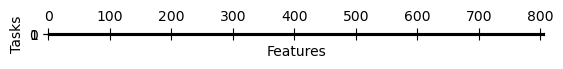

In [39]:
plt.spy(optimized_W_hinge.T)
plt.ylabel('Tasks')
plt.xlabel('Features')

In [40]:
# Create a mapping
feature_to_weight = {}
for i, feature in enumerate(feature_names):
    feature_to_weight[feature] = optimized_W_hinge[i, :]



In [ ]:
feature_to_weight

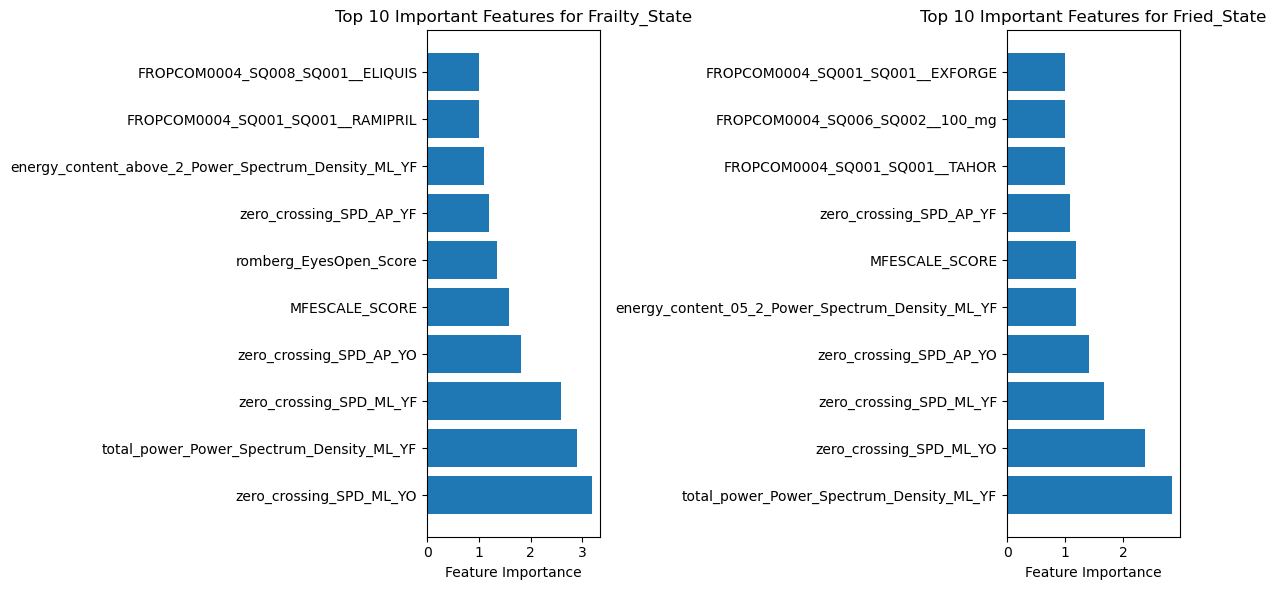

(['zero_crossing_SPD_ML_YO',
  'total_power_Power_Spectrum_Density_ML_YF',
  'zero_crossing_SPD_ML_YF',
  'zero_crossing_SPD_AP_YO',
  'MFESCALE_SCORE',
  'romberg_EyesOpen_Score',
  'zero_crossing_SPD_AP_YF',
  'energy_content_above_2_Power_Spectrum_Density_ML_YF',
  'FROPCOM0004_SQ001_SQ001__RAMIPRIL',
  'FROPCOM0004_SQ008_SQ001__ELIQUIS'],
 ['total_power_Power_Spectrum_Density_ML_YF',
  'zero_crossing_SPD_ML_YO',
  'zero_crossing_SPD_ML_YF',
  'zero_crossing_SPD_AP_YO',
  'energy_content_05_2_Power_Spectrum_Density_ML_YF',
  'MFESCALE_SCORE',
  'zero_crossing_SPD_AP_YF',
  'FROPCOM0004_SQ001_SQ001__TAHOR',
  'FROPCOM0004_SQ006_SQ002__100_mg',
  'FROPCOM0004_SQ001_SQ001__EXFORGE'])

In [77]:
# Calculate the absolute feature importance for each task
feature_importance_task1 = np.abs(optimized_W_hinge[:, 0])
feature_importance_task2 = np.abs(optimized_W_hinge[:, 1])

# Get the indices of the sorted feature importances for each task
sorted_indices_task1 = np.argsort(feature_importance_task1)[::-1]  # For 'Frailty_State'
sorted_indices_task2 = np.argsort(feature_importance_task2)[::-1]  # For 'Fried_State'

# Get the names of the top 3 important features for demonstration
# Note: You can get the top N important features based on your needs
top_features_task1 = [feature_names[i] for i in sorted_indices_task1[:10]]
top_features_task2 = [feature_names[i] for i in sorted_indices_task2[:10]]

# Plotting the feature importances for the two tasks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(top_features_task1, feature_importance_task1[sorted_indices_task1[:10]])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Frailty_State')

plt.subplot(1, 2, 2)
plt.barh(top_features_task2, feature_importance_task2[sorted_indices_task2[:10]])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Fried_State')

plt.tight_layout()
plt.show()

(top_features_task1, top_features_task2)

In [78]:
# Feature transformation
X_transformed_hinge = X_imputed.dot(optimized_W_hinge)
X_transformed_focal = X_imputed.dot(optimized_W_focal)

print(X_transformed_hinge.shape)
print(X_transformed_focal.shape)



(97, 2)
(97, 2)


In [ ]:
np.set_printoptions(suppress=True, )
X_transformed_focal.round(2)

## Feature Selection based on the W matrix

In [80]:
threshold = 0.5

abs_sum_weights_hinge = np.sum(np.abs(optimized_W_hinge), axis=1)
abs_sum_weights_focal = np.sum(np.abs(optimized_W_focal), axis=1)

In [81]:
# Indices of the features with absolute sum of weights greater than the threshold
significant_features_indices_hinge = np.where(abs_sum_weights_hinge > threshold)[0]
significant_features_indices_focal = np.where(abs_sum_weights_focal > threshold)[0]


# Extract the names of significant features
significant_features_names_hinge = [feature_names[i] for i in significant_features_indices_hinge]
significant_features_names_focal = [feature_names[i] for i in significant_features_indices_focal]

In [82]:
X_reduced_hinge = X_imputed[:, significant_features_indices_hinge]
X_reduced_focal = X_imputed[:, significant_features_indices_focal]

In [83]:
# Print the number of significant features
print('Number of significant features for Hinge Loss:', len(significant_features_names_hinge))
print('Number of significant features for Focal Loss:', len(significant_features_names_focal))

# Print the names of significant features
print('\nSignificant features for Hinge Loss:', significant_features_names_hinge)
print('\nSignificant features for Focal Loss:', significant_features_names_focal)

# Print the shape of the reduced feature matrix
print('\nShape of the reduced feature matrix for Hinge Loss:', X_reduced_hinge.shape)
print('Shape of the reduced feature matrix for Focal Loss:', X_reduced_focal.shape)



Number of significant features for Hinge Loss: 678
Number of significant features for Focal Loss: 0

Significant features for Hinge Loss: ['Gender', 'VINICODEX003', 'FROPCOM0005', 'FROPCOM0006_S1_', 'FROPCOM0006_S2_', 'FROPCOM0006_S3_', 'FROPCOM0006_S4_', 'FROPCOM0006_S5_', 'FROPCOM0006_S6_', 'FROPCOM0006_S7_', 'FROPCOM0006_S8_', 'FROPCOM0006_Total', 'FROPCOM0007_SQ002_', 'FROPCOM0007_SQ003_', 'FROPCOM0007_SQ004_', 'FROPCOM0007_SQ005_', 'FROPCOM0007_SQ006_', 'FROPCOM0007_SQ008_', 'FROPCOM0007_SQ023_', 'FROPCOM0007_SQ009_', 'FROPCOM0007_SQ010_', 'FROPCOM0007_SQ012_', 'FROPCOM0007_SQ013_', 'FROPCOM0007_SQ014_', 'FROPCOM0007_SQ015_', 'FROPCOM0007_SQ016_', 'FROPCOM0007_SQ017_', 'FROPCOM0007_SQ021_', 'FROPCOM0007_SQ024_', 'FROPCOM0007_Total', 'FROPCOM0008_SQ001_', 'FROPCOM0008_SQ002_', 'FROPCOM0009', 'FROPCOM0010', 'FROPCOM0012_SQ001_', 'FROPCOM0012_SQ002_', 'FROPCOM0013', 'FROPCOM0014', 'FROPCOM0016', 'FROPCOM0017', 'FROPCOM0018', 'FROPCOM0019', 'FROPCOM0021', 'FROPCOM0023', 'FROPCOM0024',